# Phenological phase differences

In [18]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
from agrotools import configs
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pylab import rcParams
from mtranslate import translate
import glob
import rasterio as rio
from rasterio.plot import plotting_extent
import matplotlib.colors as colors
from tqdm import tqdm

%matplotlib inline

In [2]:
prjconf = configs.ProjectConfigParser(config_file=None)

gis_raw = prjconf.get_path('GISdata', 'raw')
gis_dwd = prjconf.get_path('GISdata', 'dwd')
gis_lpis = prjconf.get_path('GISdata', 'lpis')

### Change from raster values from floats to int

In [20]:
ph_tifs = list(Path(gis_dwd/'phenology'/'tif').glob('PH_1979_2018__*.tif'))
ph_tifs

[WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__maize__accumulate_begins__corr.tif'),
 WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__maize__flowering_begins__corr.tif'),
 WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__maize__harvest__corr.tif'),
 WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__potatoes__accumulate_begins__corr.tif'),
 WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__potatoes__flowering_begins__corr.tif'),
 WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__potatoes__harvest__corr.tif'),
 WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__spring_barley__accumulate_begins__corr.tif'),
 WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__spring_barley__harvest__corr.tif'),
 WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__spring_barley__yellow_ripening__corr.tif'),
 WindowsPath('D:/02_gisdata/dwd/phenology/tif/PH_1979_2018__winter_rape__accumulate_begins__corr.tif'),
 WindowsPath('D

In [19]:
for tif in tqdm(ph_tifs):
    ph_raster = rio.open(tif)
    arr = ph_raster.read()
    arr = arr.round(0).astype(int)
    
    raster_meta = ph_raster.meta
    raster_meta.update(
        driver='GTiff',
        dtype=rio.int32,
        nodata=0)
    
    dst_path = Path(tif.parent/tif.name.replace('.tif', '__corr.tif'))
    with rio.open(str(dst_path), 'w', **raster_meta) as dst:
        dst.write(arr.astype(rio.int32))

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 52.60it/s]


### Load aux layers

In [24]:
df_de = gpd.read_file(Path(gis_lpis/'meta'/'DE_2018__lpis_data_availability.shp'))
df_de = df_de.to_crs('EPSG:32632')
df_de.head(1)

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,VARNAME_1,lpis_2018,geometry
0,86,DEU,Germany,1,Baden-Württemberg,Land,State,None,1.0,"MULTIPOLYGON (((478126.640 5284727.547, 478186..."


### Plot maps with Phenological differences

In [21]:
ph_tifs_corr = list(Path(gis_dwd/'phenology'/'tif').glob('PH_1979_2018__*__corr.tif'))

df_tifs = pd.DataFrame(ph_tifs_corr, columns=['paths'])
df_tifs = pd.concat([df_tifs, df_tifs['paths'].apply(lambda x: x.stem).str.split('__', expand=True).rename(columns={0:'year', 1:'crop', 2:'phase', 3:'corrected'})], axis=1)
display(df_tifs.head(3))

,paths,year,crop,phase,corrected
0,D:\02_gisdata\dwd\phenology\tif\PH_1979_2018__...,PH_1979_2018,maize,accumulate_begins,corr
1,D:\02_gisdata\dwd\phenology\tif\PH_1979_2018__...,PH_1979_2018,maize,flowering_begins,corr
2,D:\02_gisdata\dwd\phenology\tif\PH_1979_2018__...,PH_1979_2018,maize,harvest,corr


## Plot rasters

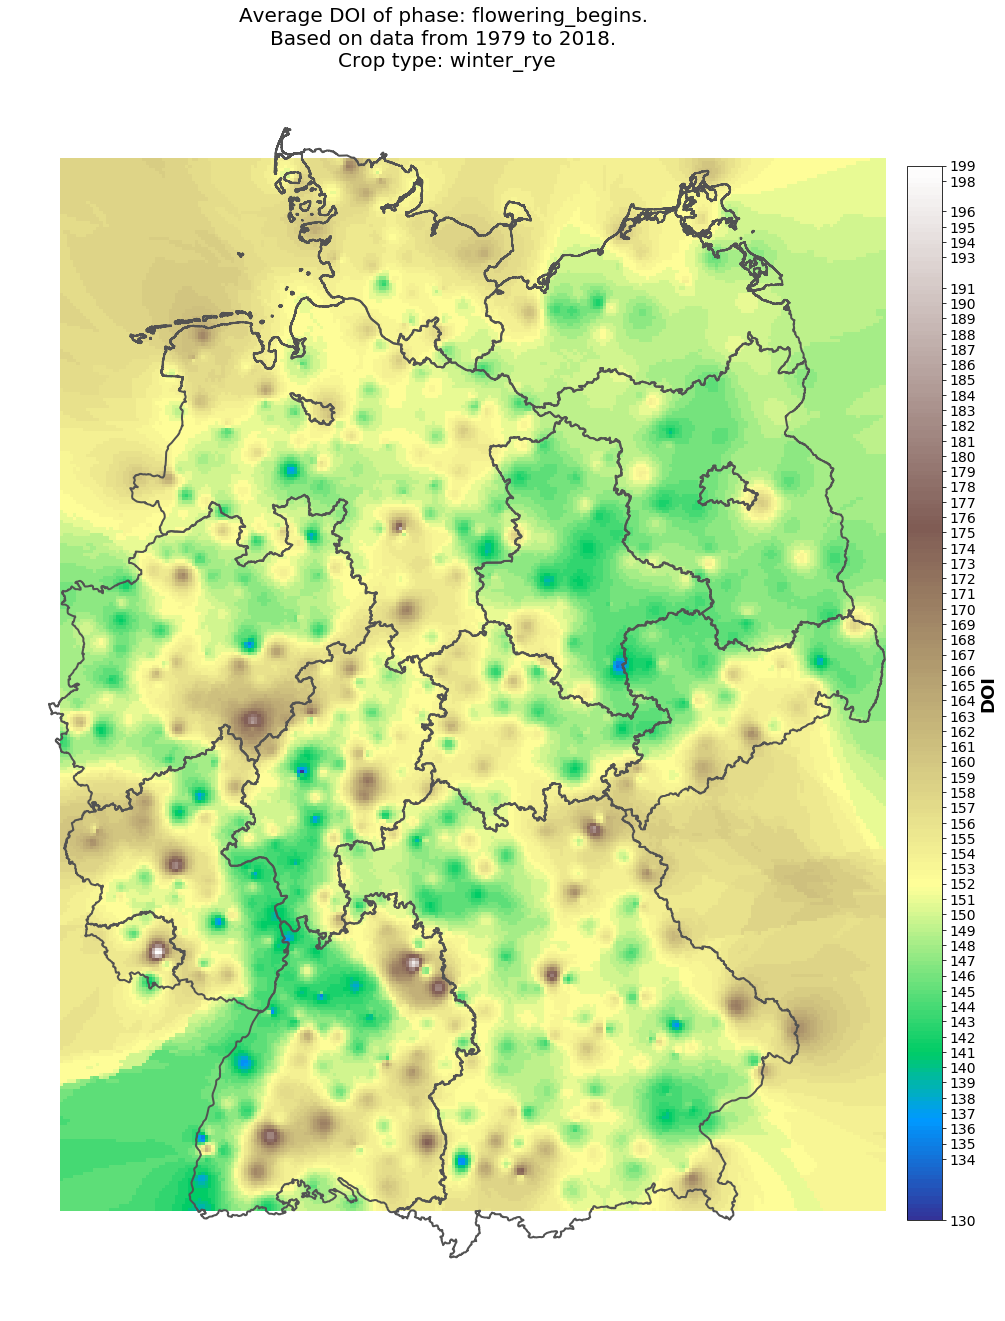

In [136]:
phases = ['accumulate_begins', 'flowering_begins', 'harvest_start', 'yellow_ripening', 'start_shot']
crops = ['maize', 'potatoes', 'summer_barley', 'winter_rape', 'winter_wheat', 'winter_rye']

year = 'PH_1979_2018'
crop = 'winter_rye'
phase = 'flowering_begins'

ph_rst = df_tifs[(df_tifs.crop == crop) & (df_tifs.year == year) & (df_tifs.phase == phase)].paths.values[0]
# ------------------------------------------------------------------------------------
with rio.open(ph_rst) as rst_crop:
    rst_extent = plotting_extent(rst_crop)
    arr_rst = rst_crop.read(1)
    
fig, ax = plt.subplots(figsize=(15,20))
ax.set_title(f'Average DOI of phase: {phase}. \nBased on data from 1979 to 2018. \nCrop type: {crop}', fontsize=20, pad=0)

# normalize color
vmin, vmax, vcenter = arr_rst.min(), arr_rst.max(), arr_rst.mean()
divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# create a normalized colorbar
cb = plt.cm.ScalarMappable(norm=divnorm, cmap=plt.cm.get_cmap('terrain', 50))


_img = ax.imshow(arr_rst, zorder=0, extent=rst_extent, cmap='terrain', norm=divnorm)
ax.set_axis_off()

# date values
df_date = pd.DataFrame(np.unique(arr_rst), columns=['DOI'])
df_date['date'] = pd.to_datetime(df_date.DOI, format='%j')
df_date['day'] = df_date.date.dt.day
df_date['month'] = df_date.date.dt.month_name(locale = 'English')
df_date['month_day'] = df_date.month.str.cat(df_date.day.astype(str), sep='-')

# cbar
cb_ticks = list(np.sort(np.unique(arr_rst)))
cbar = fig.colorbar(_img, shrink=0.75, pad=0.02, aspect=30, ticks=cb_ticks, ax=ax)
cbar.ax.set_yticklabels(cb_ticks, size=14)
cbar.ax.set_ylabel('DOI', size=18, fontweight='bold')

bundeslands = df_de.boundary.plot(edgecolor="#525252", linewidth=2, ax=ax, zorder=1)

plt.tight_layout()
fig.savefig(Path(gis_dwd/'viz'/'hist_phenology'/f'{year}__{crop}__{phase}.jpg', dpi=300, format='jpg'))